In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

from src.evaluation import (evaluate_queries, calculate_f1, recall_at_k, precision_at_k, 
                            evaluate_database_queries, evaluate_queries_in_chunked_docs)
from src.vector_database import VectorDatabase, ClusterDatabase, HnswDatabase, FaissDatabase, ChunkedDatabase
from src.helpers import process_query_results

import seaborn as sns
import matplotlib.pyplot as plt
import time
from timeit import timeit
from pympler.asizeof import asizeof
from transformers import AutoTokenizer


### Loading the sentence transformer

In [2]:
model = SentenceTransformer("all-MiniLM-L6-v2")

### Loading the documents/queries

In [3]:
base_path = Path("/Users/stighellemans/Desktop/Information_Retrieval/assignments/data")
base_small_doc_path = base_path / "full_docs_small"
base_large_doc_path = base_path / "full_docs"

small_docs = {int(re.search(r'\d+', doc_path.name).group()): doc_path for doc_path in base_small_doc_path.glob("*.txt")}
large_docs = {int(re.search(r'\d+', doc_path.name).group()): doc_path for doc_path in base_large_doc_path.glob("*.txt")}

small_queries = pd.read_csv(base_path / "dev_small_queries - dev_small_queries.csv", index_col="Query number").to_dict()["Query"]
small_query_results = pd.read_csv(base_path / "dev_query_results_small.csv", index_col="Query_number")
small_query_results = process_query_results(small_query_results)

large_queries = pd.read_csv(base_path / "dev_queries.tsv", delimiter="\t", index_col="Query number").head(1000).to_dict()["Query"]
all_large_queries = pd.read_csv(base_path / "dev_queries.tsv", delimiter="\t", index_col="Query number").to_dict()["Query"]
large_query_results = pd.read_csv(base_path / "dev_query_results.csv", index_col="Query_number")
large_query_results = process_query_results(large_query_results)

# test_queries = pd.read_csv(base_path / "queries.csv", delimiter="\t", index_col="Query number").to_dict()["Query"]


### Training the vector database

In [ ]:
db = VectorDatabase(model)
db.encode_docs(large_docs)
db.save_database("results/large_db")

In [ ]:
small_db = VectorDatabase(model)
small_db.encode_docs(small_docs)
small_db.save_database("results/small_db")

100%|██████████| 1557/1557 [00:37<00:00, 41.90it/s] 


### Loading the vector database

In [5]:
db = VectorDatabase(model)
db.load_database("results/large_db")

# cluster_db = ClusterDatabase(model, n_clusters=100)
# cluster_db.load_database("results/large_db")

# db_size = asizeof(db) / 10**6
# cluster_db_size = asizeof(cluster_db) / 10**6

# db_size, cluster_db_size

In [9]:
small_db = VectorDatabase(model)
small_db.load_database("results/small_db")

small_cluster_db = ClusterDatabase(model, n_clusters=10)
small_cluster_db.load_database("results/small_db")

### Getting top-10 retrievals

In [30]:
large_query_texts = list(all_large_queries.values())
large_query_ids = list(all_large_queries.keys())

results = db.search_queries(large_query_texts, k=10)

flattened_results = results.flatten(order='F')
repeated_query_ids = np.repeat(large_query_ids, 10)
pd.DataFrame({"Query_number": repeated_query_ids, "doc_number": flattened_results}).to_csv("results/results.csv", index=False)

Searching document batches: 100%|██████████| 101/101 [00:51<00:00,  1.97it/s]


### Document chunking

Stating the problem of max token limit

100%|██████████| 1557/1557 [00:05<00:00, 306.41it/s]


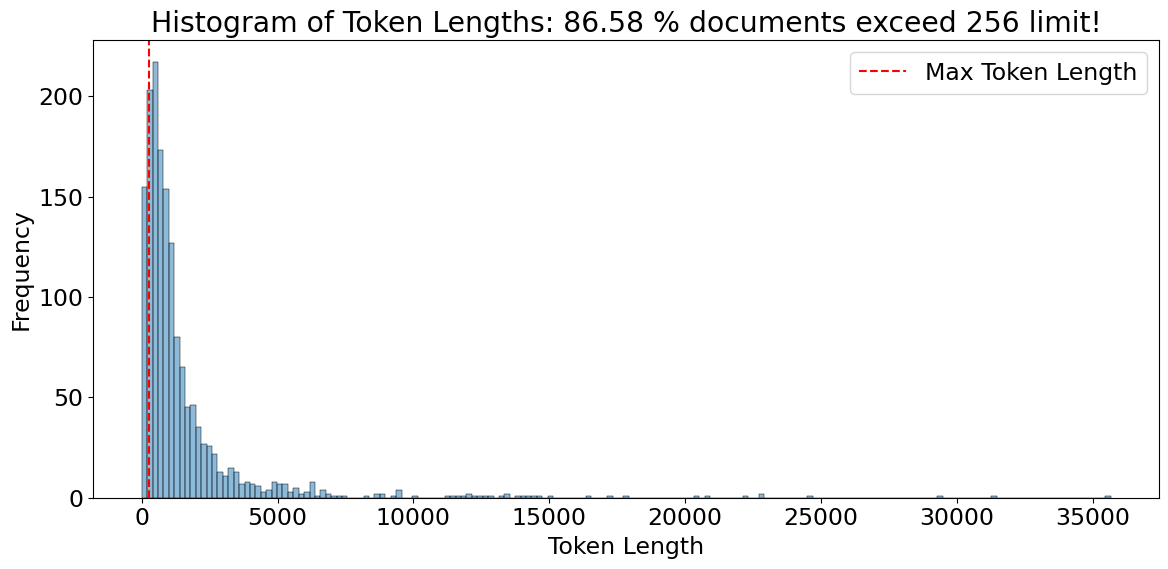

In [116]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
max_length = 256

token_lengths = []
for file_path in tqdm(small_docs.values(), total=len(small_docs)):
    with open(file_path, "r") as f:
        text = f.read()
        token_lengths.append(len(tokenizer.tokenize(text, truncation=False, verbose=False)))

# for query in tqdm(small_queries.values(), total=len(small_queries)):
#     token_lengths.append(len(tokenizer.tokenize(query, truncation=False, verbose=False)))

data = pd.DataFrame({
    'Token Lengths': token_lengths,
})

# Plot the histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=data)
plt.axvline(x=256, color='r', linestyle='--', label='Max Token Length')
plt.title(f'Histogram of Token Lengths: {data[data["Token Lengths"] > 256].shape[0] / data.shape[0] * 100:.2f} % documents exceed 256 limit!')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.rcParams.update({'font.size': 17})
plt.tight_layout()
plt.show()

In [111]:
from src.helpers import documents_chunker

stride_chunk_length = [
    (256, 32),
    (128, 16),
    (64, 8),
    (32, 4),
]


theoretical_chunks = []
for max_chunk_length, stride in stride_chunk_length:
    chunks = []
    for chunk_length in data['Token Lengths']:
        chunks.append(np.ceil((chunk_length - max_chunk_length) / stride) + 1)
    theoretical_chunks.append(np.sum(chunks))


for chunk_length, stride in stride_chunk_length:
    print(f"Chunk Length: {chunk_length}, Stride: {stride}")
    chunked_db = ChunkedDatabase(model)
    chunked_db.encode_docs(small_docs, chunk_length=chunk_length, stride=stride)
    chunked = evaluate_queries_in_chunked_docs(small_queries, small_query_results, k_values=[1, 3, 5, 10], database=chunked_db)
    print(chunked, asizeof(chunked_db) / 10**6, chunked_db.doc_vectors.shape[0])


chunked_db = ChunkedDatabase(model)
chunked_db.encode_docs(small_docs, chunk_length=128, stride=16)


chunked_db.save_database("results/chunked_small_db")

22363 document vectors encoded:  99%|█████████▊| 1535/1557 [01:47<00:01, 12.21it/s]

encoding the last batch of 364 documents


22363 document vectors encoded:  99%|█████████▊| 1536/1557 [01:49<00:01, 14.08it/s]


Searching document batches: 100%|██████████| 5/5 [00:00<00:00, 37.68it/s]


Multiple insufficient, trying with 100.0


Searching document batches: 100%|██████████| 1/1 [00:00<00:00, 109.49it/s]


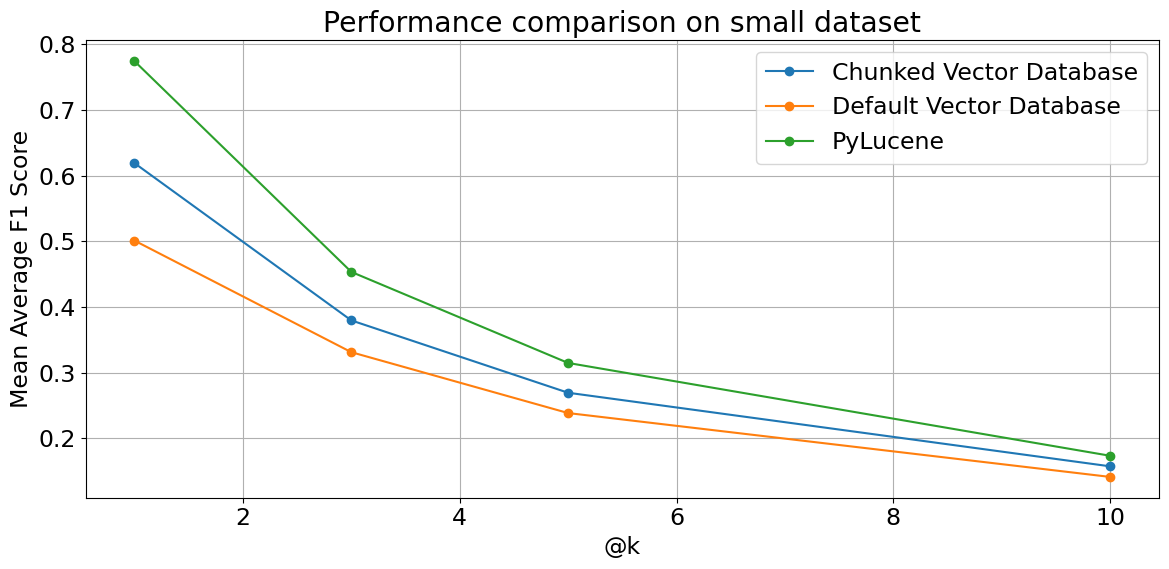

In [113]:
chunked_db = ChunkedDatabase(model)
chunked_db.load_database("results/chunked_small_db")

chunked = evaluate_queries_in_chunked_docs(small_queries, small_query_results, k_values=[1, 3, 5, 10], database=chunked_db)
default = evaluate_database_queries(small_queries, small_query_results, k_values=[1, 3, 5, 10], database=small_db)

pylucene = {1: {'Precision': 0.7782258064516129, 'Recall': 0.7701612903225806},
 3: {'Precision': 0.30376344086021506, 'Recall': 0.8931451612903226},
 5: {'Precision': 0.1895161290322581, 'Recall': 0.9274193548387096},
 10: {'Precision': 0.09556451612903227, 'Recall': 0.9354838709677419}}

# Calculate F1 scores for test and default
test_f1 = {k: calculate_f1(v['Precision'], v['Recall']) for k, v in chunked.items()}
default_f1 = {k: calculate_f1(v['Precision'], v['Recall']) for k, v in default.items()}
pylucene_f1 = {k: calculate_f1(v['Precision'], v['Recall']) for k, v in pylucene.items()}

# Plot the F1 scores
plt.figure(figsize=(12, 6))
plt.plot(list(test_f1.keys()), list(test_f1.values()), marker='o', label='Chunked Vector Database')
plt.plot(list(default_f1.keys()), list(default_f1.values()), marker='o', label='Default Vector Database')
plt.plot(list(pylucene_f1.keys()), list(pylucene_f1.values()), marker='o', label='PyLucene')
plt.xlabel('@k')
plt.ylabel('Mean Average F1 Score')
plt.title('Performance comparison on small dataset')
plt.legend()
plt.grid(True)
plt.rcParams.update({'font.size': 17})
plt.tight_layout()
plt.show()

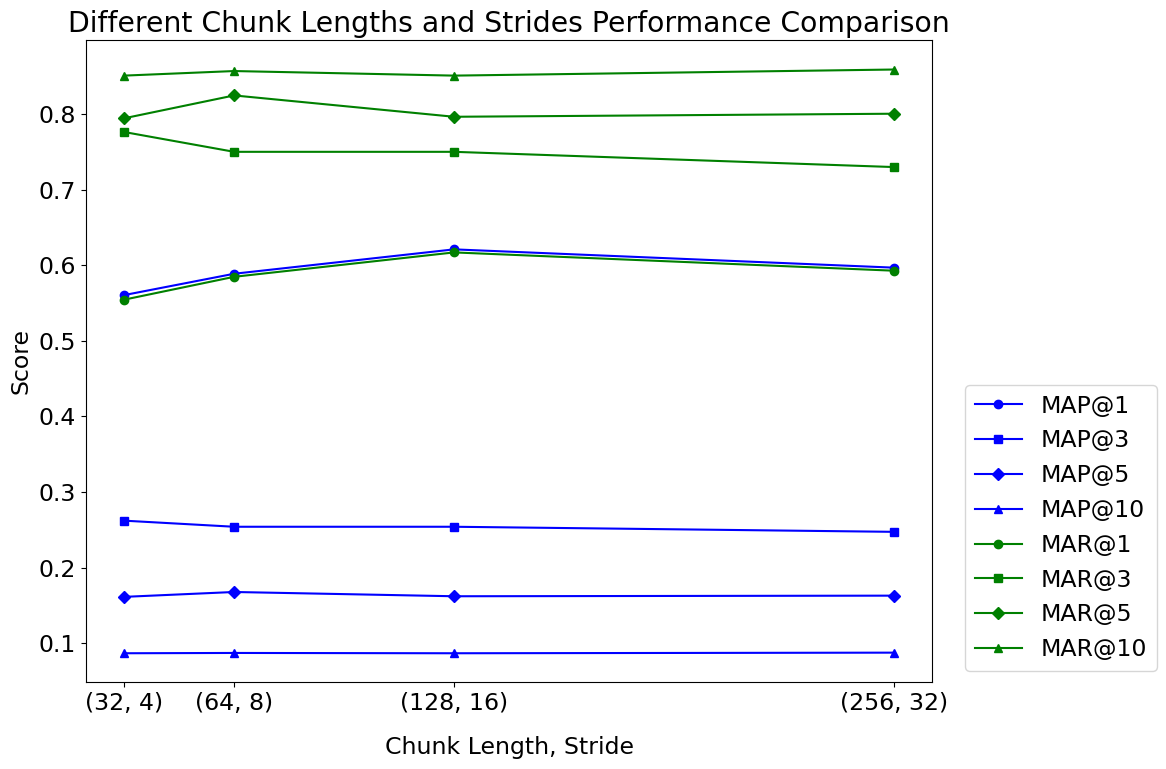

In [109]:
results = pd.read_csv("results/chunking_exp.csv")
# Define colors and markers for precision and recall
colors = {
    'Precision': 'blue',
    'Recall': 'green'
}
markers = {
    1: 'o',
    3: 's',
    5: 'D',
    10: '^'
}

# Plot the line plot for each chunked_length
plt.figure(figsize=(12, 8))
metric_labels = {
    'mean.1.Precision': 'MAP@1',
    'mean.3.Precision': 'MAP@3',
    'mean.5.Precision': 'MAP@5',
    'mean.10.Precision': 'MAP@10',
    'mean.1.Recall': 'MAR@1',
    'mean.3.Recall': 'MAR@3',
    'mean.5.Recall': 'MAR@5',
    'mean.10.Recall': 'MAR@10'
}

for metric, label in metric_labels.items():
    metric_type = 'Precision' if 'Precision' in metric else 'Recall'
    k_value = int(metric.split('.')[1])
    plt.plot(results['chunked_length'], results[metric], 
             marker=markers[k_value], color=colors[metric_type], label=label)

# Add stride information to the x-axis labels
chunk_stride_labels = [f'({cl}, {st})' for cl, st in zip(results['chunked_length'], results['stride'])]
plt.xticks(results['chunked_length'], chunk_stride_labels)

plt.title('Different Chunk Lengths and Strides Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Chunk Length, Stride', labelpad=15)
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.025, 0), loc='lower left')
plt.tight_layout()
plt.show()

In [8]:
chunked_db.save_database("results/chunked_small_db")

### Visualization of clusters

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


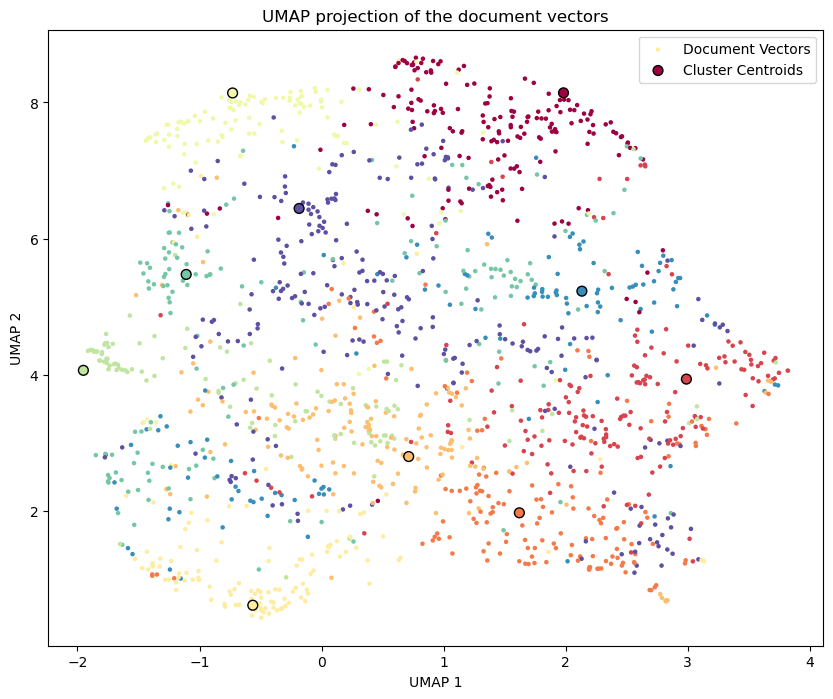

In [ ]:
import umap

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(small_cluster_db.doc_vectors)

cluster_embedding = reducer.transform(small_cluster_db.kmeans.cluster_centers_)

include = (embedding < 10).all(axis=1)
embedding = embedding[include]

# Plot the 2D UMAP
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=small_cluster_db.kmeans.labels_[include], cmap='Spectral', label='Document Vectors')
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=50, c=np.arange(cluster_embedding.shape[0]), cmap='Spectral', edgecolor='black', label='Cluster Centroids')
plt.title('UMAP projection of the document vectors')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

### Euclidean distance vs cosine similarity

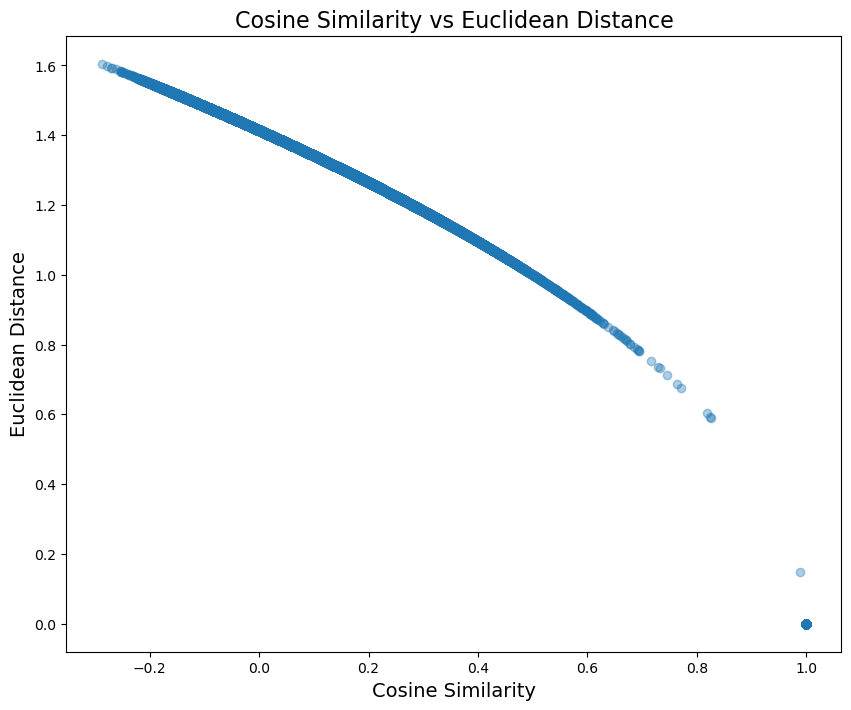

In [ ]:
from scipy.spatial.distance import pdist, squareform

cosine_similarity = np.dot(small_db.doc_vectors, small_db.doc_vectors.T).flatten()
# Calculate the Euclidean distance between all vectors
euclidean_distances = squareform(pdist(small_db.doc_vectors, metric='euclidean'))
euclidean_distances = euclidean_distances.flatten()

# Plot the cosine similarity and euclidean distance
plt.figure(figsize=(10, 8))
plt.scatter(cosine_similarity, euclidean_distances, alpha=0.2)
plt.title('Cosine Similarity vs Euclidean Distance', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Euclidean Distance', fontsize=14)
plt.show()

### Comparison between Sentence Transformers

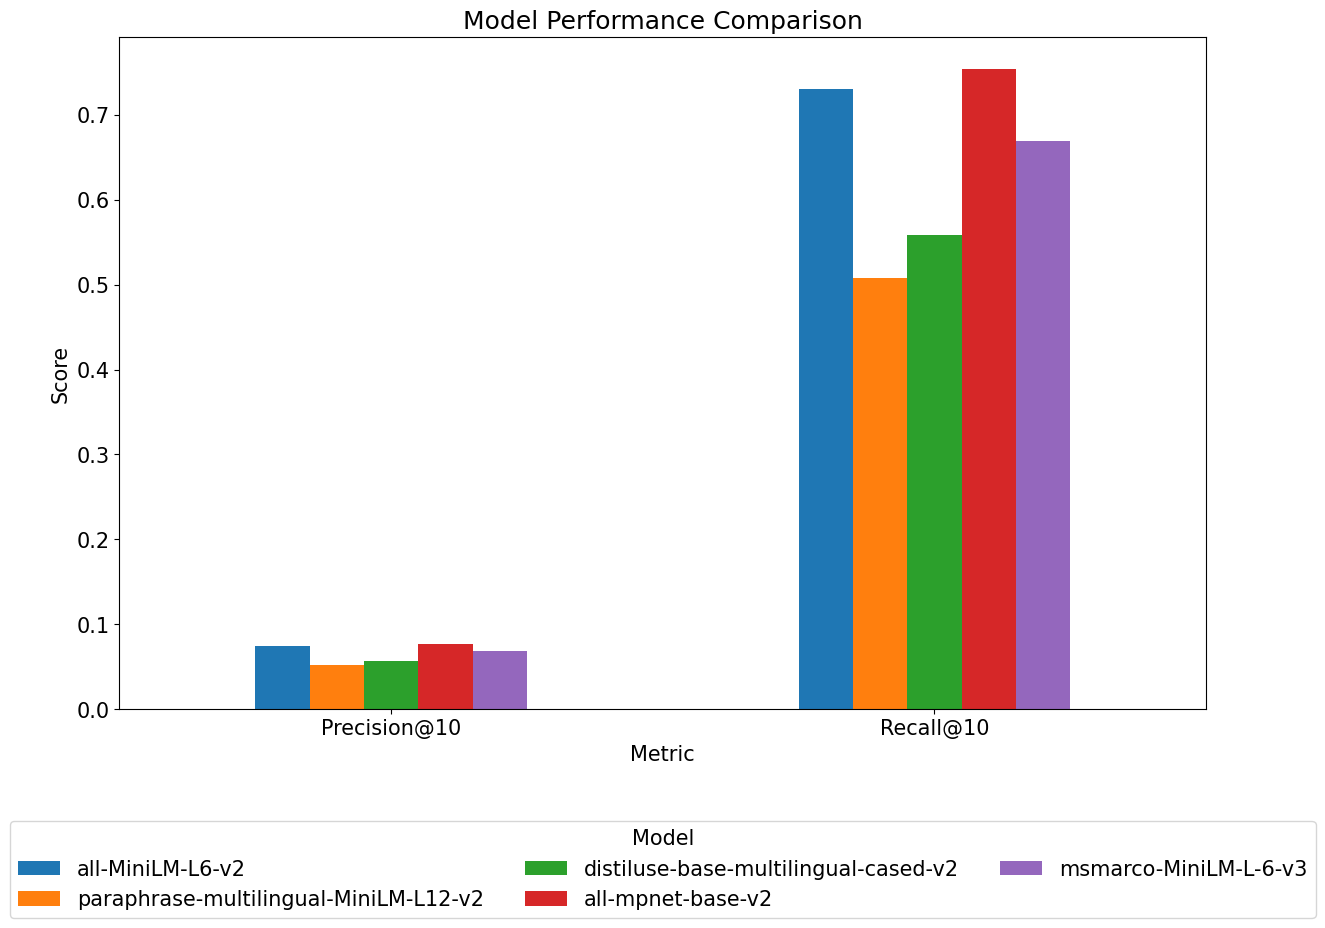

In [ ]:
model_performance = pd.read_csv("results/model_performance_comparison.csv", index_col="Model")
model_performance.T.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.show()

### Evaluation

In [5]:
evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=db)

Searching document batches: 100%|██████████| 101/101 [00:09<00:00, 10.41it/s]


{1: {'Precision': 0.492, 'Recall': 0.03281815049276214},
 3: {'Precision': 0.3686666666666667, 'Recall': 0.07295199141942546},
 5: {'Precision': 0.3084, 'Recall': 0.10118826400598947},
 10: {'Precision': 0.2297, 'Recall': 0.1496890959589684}}

In [ ]:
evaluate_database_queries(small_queries, small_query_results, k_values=[1, 3, 5, 10], database=small_db)

Searching document batches: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s]


{1: {'Precision': 0.35080645161290325, 'Recall': 0.3467741935483871},
 3: {'Precision': 0.17607526881720428, 'Recall': 0.5181451612903226},
 5: {'Precision': 0.11693548387096774, 'Recall': 0.5745967741935484},
 10: {'Precision': 0.06814516129032258, 'Recall': 0.6693548387096774}}

In [ ]:
cluster_db = ClusterDatabase(model, n_clusters=100)
cluster_db.load_database("results/large_db")
evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=cluster_db, top_c=12)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Searching clusters: 100%|██████████| 100/100 [00:06<00:00, 15.22it/s]


{1: {'Precision': 0.344, 'Recall': 0.02303401457192344},
 3: {'Precision': 0.29866666666666664, 'Recall': 0.0590769697829329},
 5: {'Precision': 0.268, 'Recall': 0.08793259524120306},
 10: {'Precision': 0.2172, 'Recall': 0.14139325610996295}}

In [ ]:
%%timeit
evaluate_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=cluster_db, top_c=12)

Searching clusters: 100%|██████████| 100/100 [00:06<00:00, 15.55it/s]

7.36 s ± 468 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Cluster hyperparameters

In [ ]:
n_clusters = [2, 5, 10, 50, 100, 200]
n_clusters = [200]

k = 10
max_partitions = 10

results = []

def wrappper():
    evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=db)

query_time = timeit(wrappper, number=5) / 5

metrics =  evaluate_database_queries(large_queries, large_query_results, k_values=[k], database=db)[k]
results.append({"database": "Vector Database", "clusters": 0, 
                "top_c": 0, f"MAP@{k}": metrics["Precision"], 
                f"MAR@{k}": metrics["Recall"], 
                f"MAF1@{k}": calculate_f1(metrics["Precision"], metrics["Recall"]),
                "cluster_time": 0, "query_time": query_time
                })

n = 0
for n_cluster in n_clusters:
    print(n_cluster)

    start_time = time.time()
    large_cluster_db = ClusterDatabase(model, n_clusters=n_cluster)
    large_cluster_db.load_database("results/large_db")
    cluster_time = time.time() - start_time
    print(f"Time taken for creating {n_cluster} clusters: {cluster_time} seconds") 
    top_c_values = np.unique(np.linspace(1, n_cluster, num=max_partitions, dtype=int))

    for top_c in tqdm(top_c_values, total=len(top_c_values)):
        def wrappper():
            evaluate_database_queries(large_queries, large_query_results, k_values=[k], 
                                   database=large_cluster_db, top_c=top_c, verbose=False
                                   )[k]

        query_time = timeit(wrappper, number=5) / 5

        metrics = evaluate_database_queries(large_queries, large_query_results, k_values=[k], 
                                   database=large_cluster_db, top_c=top_c, verbose=False
                                   )[k]
        results.append({"database": "Cluster Database", "clusters": n_cluster, 
                        "top_c": top_c, f"MAP@{k}": metrics["Precision"], 
                        f"MAR@{k}": metrics["Recall"], 
                        f"MAF1@{k}": calculate_f1(metrics["Precision"], metrics["Recall"]),
                        "cluster_time": cluster_time, "query_time": query_time
                        })



results = pd.DataFrame(results)
results.to_csv("results/cluster_results.csv", index=False)

200
Time taken for creating 200 clusters: 163.3946771621704 seconds


100%|██████████| 10/10 [31:56<00:00, 191.66s/it]


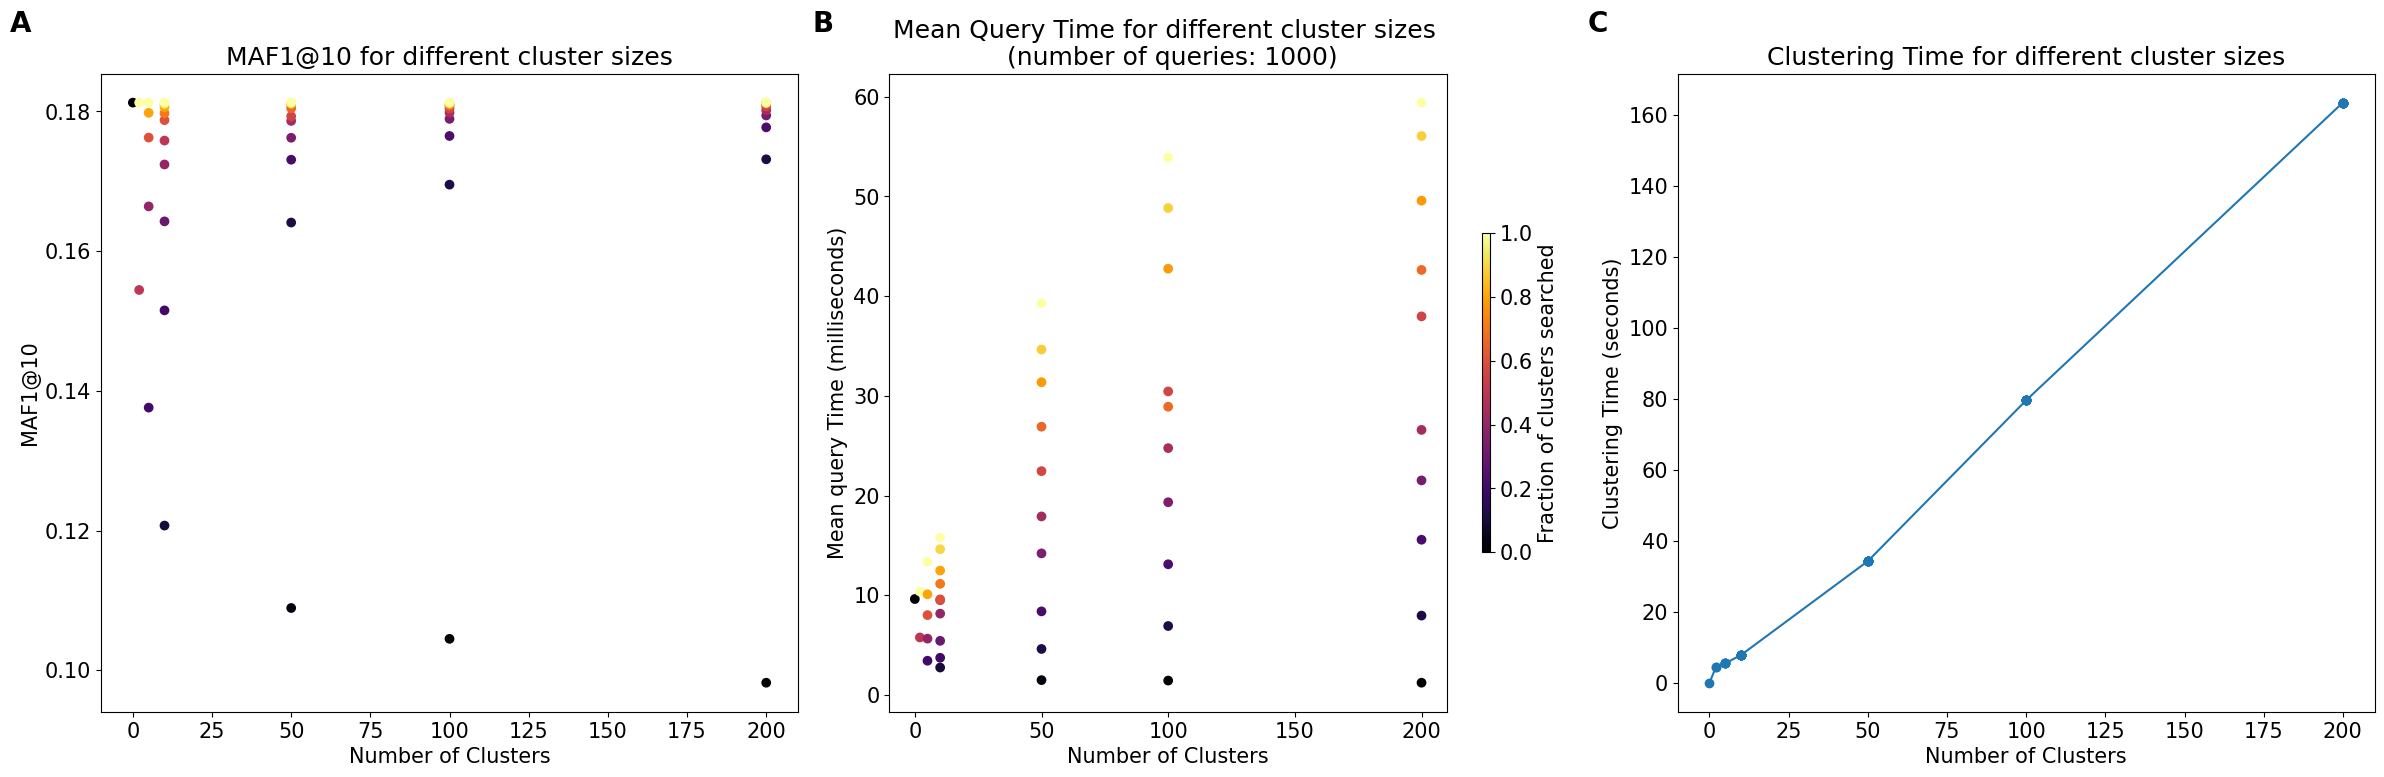

In [16]:
import matplotlib.colors as mcolors

# Set font size
plt.rcParams.update({'font.size': 15})

k = 10
n_queries = len(large_queries)

results = pd.read_csv("results/cluster_results.csv")

# Extract data
x1 = results["clusters"]
y1 = results[f"MAF1@{k}"]
hue1 = results["top_c"] / results["clusters"].replace(0, 1)

# Normalize the hue values for the colormap
norm1 = mcolors.Normalize(vmin=hue1.min(), vmax=hue1.max())
cmap1 = plt.cm.inferno

# Extract data + calculate query time per query in milliseconds
x2 = results["clusters"]
y2 = results["query_time"] / n_queries * 1000
hue2 = results["top_c"] / results["clusters"].replace(0, 1)

# Normalize the hue values for the colormap
norm2 = mcolors.Normalize(vmin=hue2.min(), vmax=hue2.max())
cmap2 = plt.cm.inferno

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharey=False)

# Create the first plot for MAF1@k
scatter1 = ax1.scatter(x1, y1, c=hue1, cmap=cmap1, norm=norm1)
ax1.set_title(f"MAF1@{k} for different cluster sizes")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel(f"MAF1@{k}")
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Create the second plot for query_time
scatter2 = ax2.scatter(x2, y2, c=hue2, cmap=cmap2, norm=norm2)
ax2.set_title("Mean Query Time for different cluster sizes \n (number of queries: 1000)")
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Mean query Time (milliseconds)")
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Add colorbar for the second plot
cbar2 = plt.colorbar(scatter2, ax=ax2, label="Fraction of clusters searched", orientation="vertical", aspect=40, shrink=0.5)

# Plot the line plot for cluster_time
ax3.plot(results["clusters"], results["cluster_time"], marker='o', linestyle='-')
ax3.set_title("Clustering Time for different cluster sizes")
ax3.set_xlabel("Number of Clusters")
ax3.set_ylabel("Clustering Time (seconds)")
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Show the figure
plt.tight_layout()
plt.show()


### Hierarchical Navigable Small World (HNSW)

#### Own implementation
(Doesn't get good results)

In [ ]:
metrics = []

for n_neighbors in [5, 10, 15, 20, 25, 30]:
    hnsw_db = HnswDatabase(model, n_neighbors=n_neighbors)

    hnsw_db.load_database("results/small_db")

    
    probes = [5, 10, 30, 50, 100, 200]
    for n_probes in probes:
        print(n_neighbors, n_probes)
        metrics.append({"n_neighbours": n_neighbors, "n_probes": n_probes, **evaluate_queries(small_queries, small_query_results, k_values=[1, 3, 5, 10], database=hnsw_db, n_probes=n_probes)[10]})

metrics = pd.DataFrame(metrics)
metrics

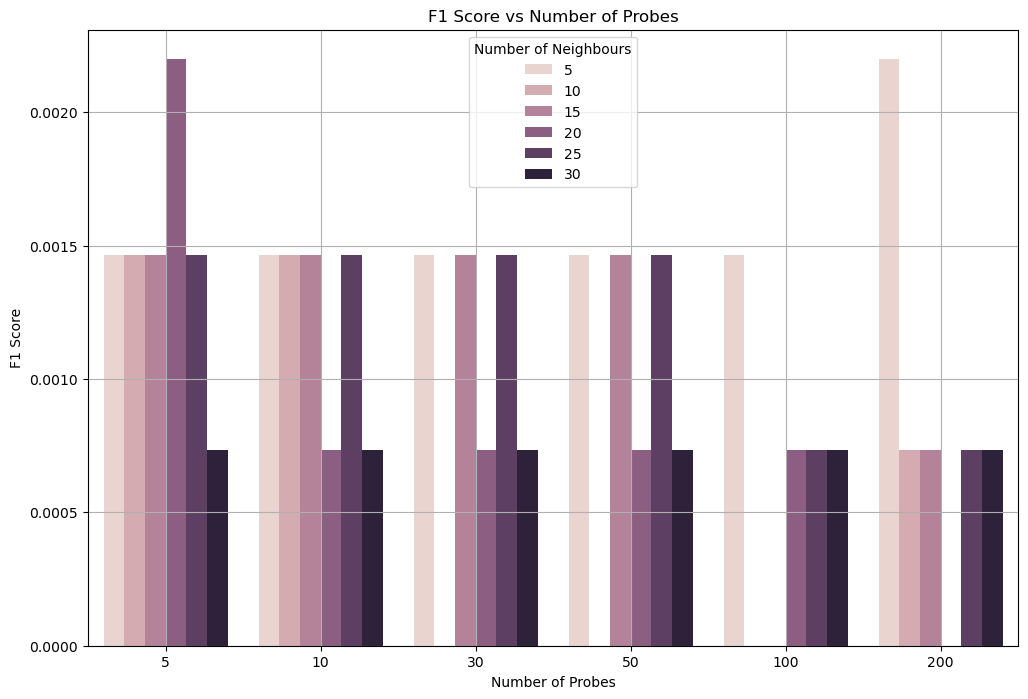

In [ ]:
metrics["F1"] = metrics.apply(lambda row: calculate_f1(row["Precision"], row["Recall"]), axis=1)
metrics

### FAISS

Flat database evaluation

In [15]:
faiss_db = FaissDatabase(model, index_type="Flat")
faiss_db.load_database("results/large_db")

metrics = evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=faiss_db)

# Evaluate the query time performance
def wrapper():
    evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=faiss_db)

query_time = timeit(wrapper, number=5) / 5 / len(large_queries)
faiss_db_size = asizeof(faiss_db) / 10**6

metrics, query_time, faiss_db_size

({1: {'Precision': 0.492, 'Recall': 0.03281815049276214},
  3: {'Precision': 0.3686666666666667, 'Recall': 0.07295199141942546},
  5: {'Precision': 0.3084, 'Recall': 0.10118826400598947},
  10: {'Precision': 0.2297, 'Recall': 0.1496890959589684}},
 0.0011449412334011868,
 824.02752)

Clustering hyperparameter tuning

In [7]:
n_clusters = [2, 5, 10, 50, 100, 200]

k = 10
max_partitions = 10

results = []

def wrappper():
    evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=faiss_db)

query_time = timeit(wrappper, number=5) / 5

metrics =  evaluate_database_queries(large_queries, large_query_results, k_values=[k], database=faiss_db)[k]
results.append({"database": "Vector Database", "clusters": 0, 
                "top_c": 0, f"MAP@{k}": metrics["Precision"], 
                f"MAR@{k}": metrics["Recall"], 
                f"MAF1@{k}": calculate_f1(metrics["Precision"], metrics["Recall"]),
                "cluster_time": 0, "query_time": query_time
                })

n = 0
for n_cluster in n_clusters:
    print(n_cluster)

    start_time = time.time()
    large_cluster_db = FaissDatabase(model, index_type="Clustering", n_clusters=100)
    large_cluster_db.load_database("results/large_db")
    cluster_time = time.time() - start_time
    print(f"Time taken for creating {n_cluster} clusters: {cluster_time} seconds") 
    top_c_values = np.unique(np.linspace(1, n_cluster, num=max_partitions, dtype=int))

    for top_c in tqdm(top_c_values, total=len(top_c_values)):
        def wrappper():
            evaluate_database_queries(large_queries, large_query_results, k_values=[k], 
                                   database=large_cluster_db, top_c=int(top_c), verbose=False
                                   )[k]

        query_time = timeit(wrappper, number=5) / 5

        metrics = evaluate_database_queries(large_queries, large_query_results, k_values=[k], 
                                   database=large_cluster_db, top_c=int(top_c), verbose=False
                                   )[k]
        results.append({"database": "Cluster Database", "clusters": n_cluster, 
                        "top_c": top_c, f"MAP@{k}": metrics["Precision"], 
                        f"MAR@{k}": metrics["Recall"], 
                        f"MAF1@{k}": calculate_f1(metrics["Precision"], metrics["Recall"]),
                        "cluster_time": cluster_time, "query_time": query_time
                        })



results = pd.DataFrame(results)
results.to_csv("results/faiss_cluster_results.csv", index=False)

2
Time taken for creating 2 clusters: 1.3488028049468994 seconds


100%|██████████| 2/2 [00:11<00:00,  5.57s/it]


5
Time taken for creating 5 clusters: 1.1871249675750732 seconds


100%|██████████| 5/5 [00:36<00:00,  7.25s/it]


10
Time taken for creating 10 clusters: 0.9377610683441162 seconds


100%|██████████| 10/10 [01:33<00:00,  9.35s/it]


50
Time taken for creating 50 clusters: 1.4430019855499268 seconds


100%|██████████| 10/10 [04:33<00:00, 27.35s/it]


100
Time taken for creating 100 clusters: 1.4185900688171387 seconds


100%|██████████| 10/10 [07:55<00:00, 47.57s/it]


200
Time taken for creating 200 clusters: 1.358290195465088 seconds


100%|██████████| 10/10 [10:57<00:00, 65.78s/it]


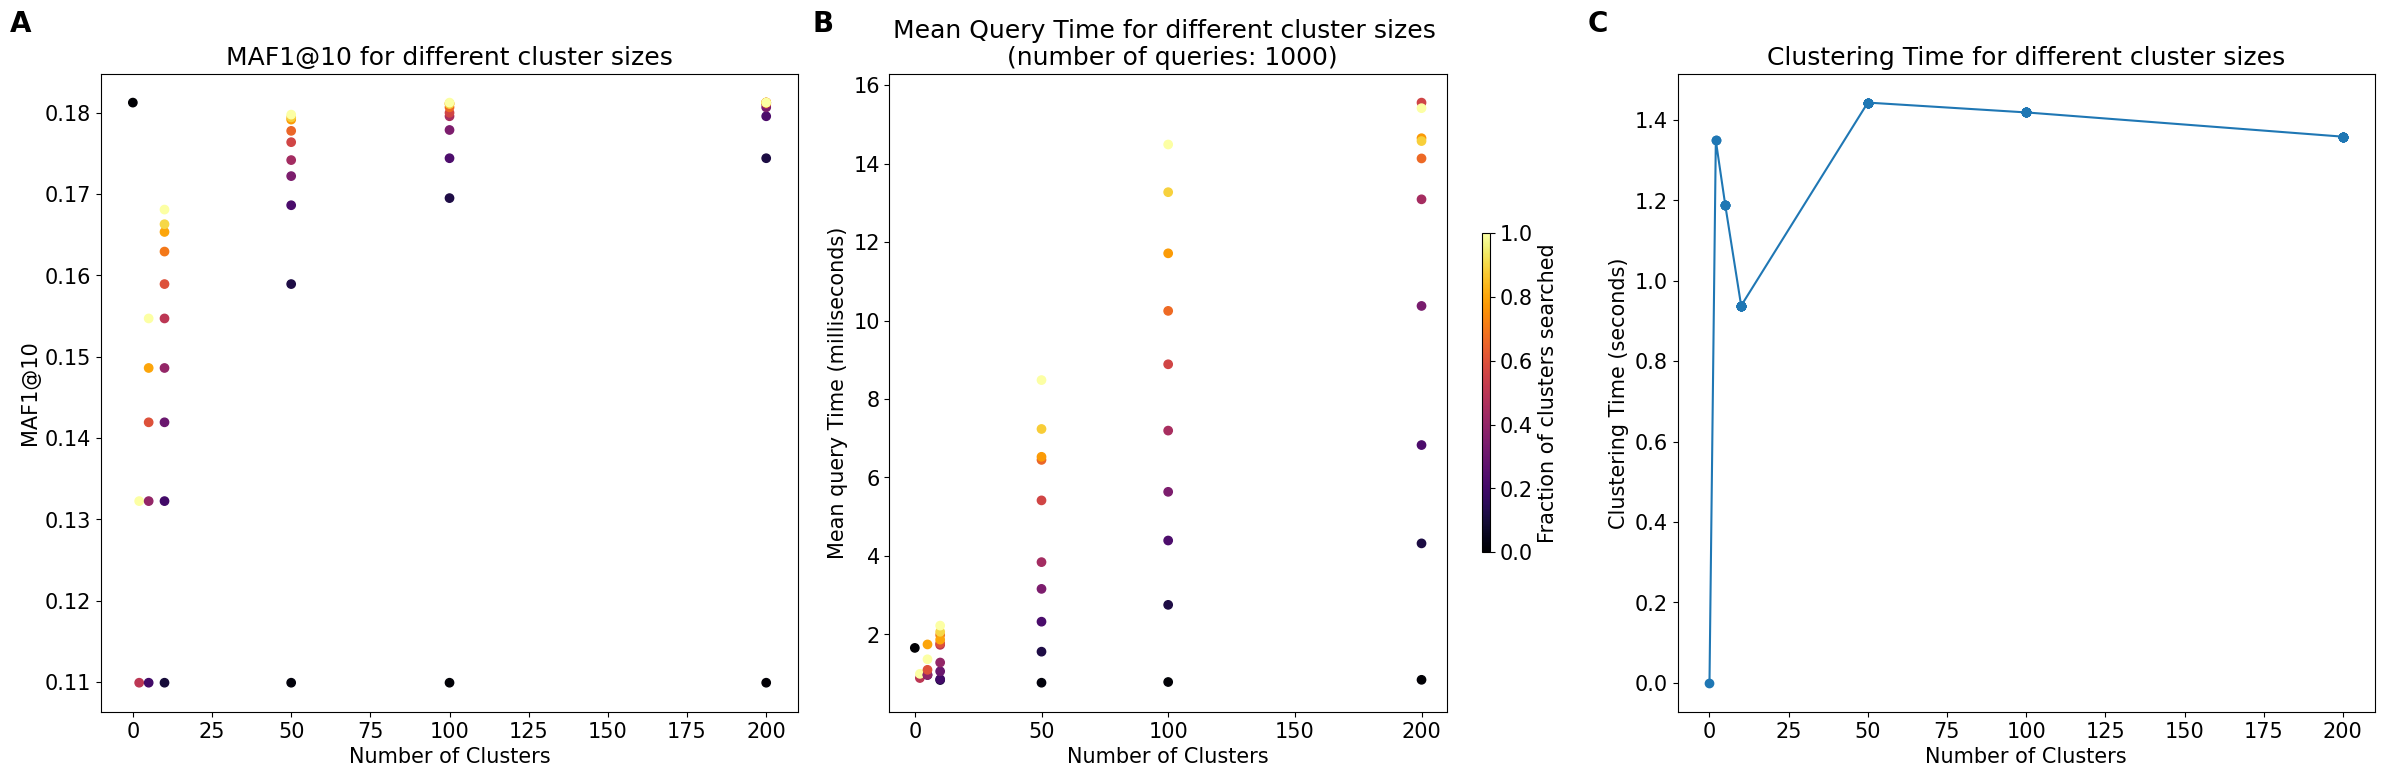

In [13]:
import matplotlib.colors as mcolors

# Set font size
plt.rcParams.update({'font.size': 15})

k = 10
n_queries = len(large_queries)

results = pd.read_csv("results/faiss_cluster_results.csv")

# Extract data
x1 = results["clusters"]
y1 = results[f"MAF1@{k}"]
hue1 = results["top_c"] / results["clusters"].replace(0, 1)

# Normalize the hue values for the colormap
norm1 = mcolors.Normalize(vmin=hue1.min(), vmax=hue1.max())
cmap1 = plt.cm.inferno

# Extract data + calculate query time per query in milliseconds
x2 = results["clusters"]
y2 = results["query_time"] / n_queries * 1000
hue2 = results["top_c"] / results["clusters"].replace(0, 1)

# Normalize the hue values for the colormap
norm2 = mcolors.Normalize(vmin=hue2.min(), vmax=hue2.max())
cmap2 = plt.cm.inferno

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharey=False)

# Create the first plot for MAF1@k
scatter1 = ax1.scatter(x1, y1, c=hue1, cmap=cmap1, norm=norm1)
ax1.set_title(f"MAF1@{k} for different cluster sizes")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel(f"MAF1@{k}")
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Create the second plot for query_time
scatter2 = ax2.scatter(x2, y2, c=hue2, cmap=cmap2, norm=norm2)
ax2.set_title("Mean Query Time for different cluster sizes \n (number of queries: 1000)")
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Mean query Time (milliseconds)")
ax2.text(-0.1, 1.1, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Add colorbar for the second plot
cbar2 = plt.colorbar(scatter2, ax=ax2, label="Fraction of clusters searched", orientation="vertical", aspect=40, shrink=0.5)

# Plot the line plot for cluster_time
ax3.plot(results["clusters"], results["cluster_time"], marker='o', linestyle='-')
ax3.set_title("Clustering Time for different cluster sizes")
ax3.set_xlabel("Number of Clusters")
ax3.set_ylabel("Clustering Time (seconds)")
ax3.text(-0.1, 1.1, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

# Show the figure
plt.tight_layout()
plt.show()


Clustering database evaluation

In [15]:
cluster_faiss_db = FaissDatabase(model, index_type="Clustering", n_clusters=200)
cluster_faiss_db.load_database("results/large_db")

metrics = evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=cluster_faiss_db, top_c=4)

# Evaluate the query time performance
def wrapper():
    evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=cluster_faiss_db, top_c=4)

query_time = timeit(wrapper, number=5) / 5 / len(large_queries)
cluster_faiss_db_size = asizeof(cluster_faiss_db) / 10**6
metrics, query_time, cluster_faiss_db_size

({1: {'Precision': 0.428, 'Recall': 0.028525229267100983},
  3: {'Precision': 0.311, 'Recall': 0.06118466557075286},
  5: {'Precision': 0.25360000000000005, 'Recall': 0.08269578724155449},
  10: {'Precision': 0.1867, 'Recall': 0.1212159744118995}},
 0.0014883855500025676,
 824.027864)

HNSW database

In [ ]:
# Hyperparameter tuning
n_neighbours = [2, 5, 8, 16]
efConstructions = [10, 50, 100, 200]
efSearches = [10, 20, 50, 100]
results = []
for nn in tqdm(n_neighbours, total=len(n_neighbours)):
    for efConstruction in efConstructions:
        for efSearch in efSearches:
            print(f"n_neighbours: {nn}, efConstruction: {efConstruction}, efSearch: {efSearch}")
            hnsw_faiss_db = FaissDatabase(
                model,
                index_type="HNSW",
                n_neighbours=nn,
                efConstruction=efConstruction,
                efSearch=efSearch,
            )
            hnsw_faiss_db.load_database("results/large_db")

            metrics = evaluate_database_queries(
                large_queries,
                large_query_results,
                k_values=[1, 3, 5, 10],
                database=hnsw_faiss_db,
            )

            # Evaluate the query time performance
            def wrapper():
                evaluate_database_queries(
                    large_queries,
                    large_query_results,
                    k_values=[1, 3, 5, 10],
                    database=hnsw_faiss_db,
                )

            query_time = timeit(wrapper, number=5) / 5 / len(large_queries)
            metrics, query_time

            results.append(
                {
                    "n_neighbours": nn,
                    "efConstruction": efConstruction,
                    "efSearch": efSearch,
                    "Precision": metrics[10]["Precision"],
                    "Recall": metrics[10]["Recall"],
                    "F1": calculate_f1(metrics[10]["Precision"], metrics[10]["Recall"]),
                    "Query_time": query_time,
                    "Database size": asizeof(hnsw_faiss_db),
                }
            )
results = pd.DataFrame(results)
results.to_csv("results/hnsw_faiss_results.csv", index=False)


In [110]:
# construct the database with the best hyperparameters
n_neighbours = 16
efConstruction = 100
efSearch = 100

# Get best results
hnsw_faiss_db = FaissDatabase(model, index_type="HNSW", n_neighbours=n_neighbours, 
                              efConstruction=efConstruction, efSearch=efSearch)
hnsw_faiss_db.load_database("results/large_db")

metrics = evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=hnsw_faiss_db)

# Evaluate the query time performance
def wrapper():
    evaluate_database_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=hnsw_faiss_db)

query_time = timeit(wrapper, number=5) / 5 / len(large_queries)
hnsw_faiss_db_size = asizeof(hnsw_faiss_db) / 10**6
metrics, query_time, hnsw_faiss_db_size

({1: {'Precision': 0.473, 'Recall': 0.03150571625946878},
  3: {'Precision': 0.3553333333333334, 'Recall': 0.07024746569918768},
  5: {'Precision': 0.29680000000000006, 'Recall': 0.0972940499941671},
  10: {'Precision': 0.22119999999999998, 'Recall': 0.1441213562021652}},
 0.0007123004500055685,
 791.023968)

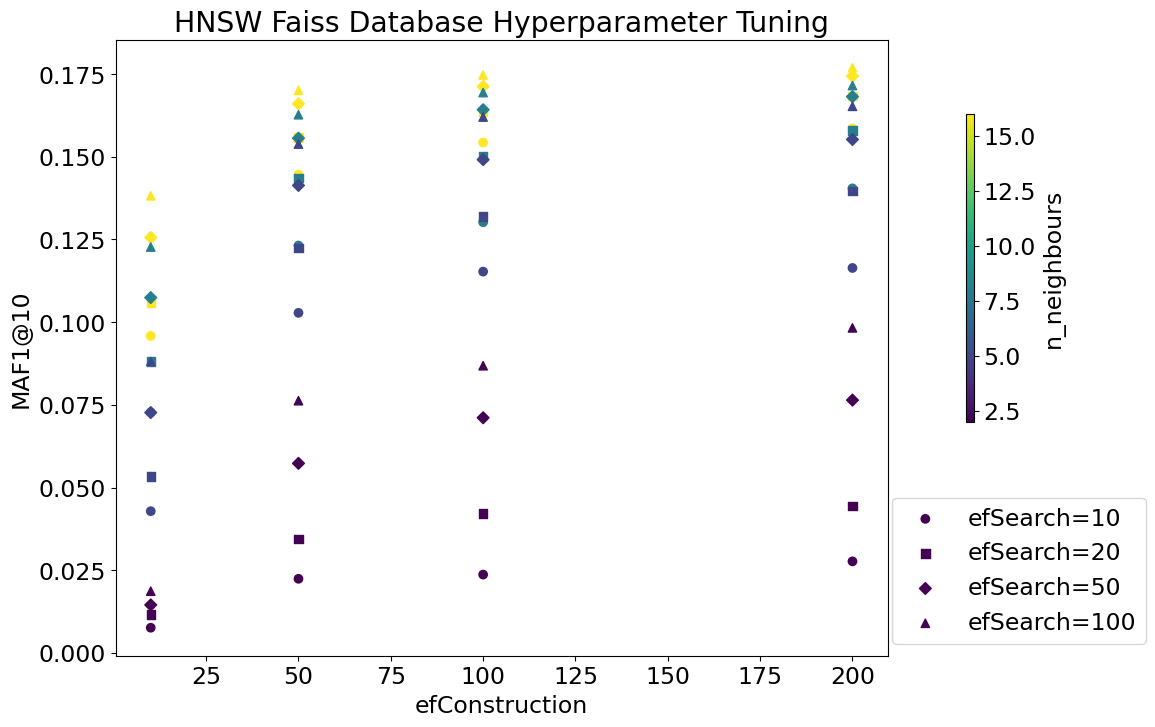

In [117]:
results = pd.read_csv("results/hnsw_faiss_results.csv")

# Define a mapping from efSearch to marker types
marker_map = {10: 'o', 20: 's', 50: 'D', 100: '^'}

# Create a scatter plot with different markers for efSearch
fig, ax = plt.subplots(figsize=(12, 8))
sc = None
for efSearch, marker in marker_map.items():
    subset = results[results['efSearch'] == efSearch]
    sc = ax.scatter(subset['efConstruction'], subset['F1'], c=subset['n_neighbours'], cmap='viridis', label=f'efSearch={efSearch}', marker=marker)

# Add colorbar for n_neighbours
cbar = plt.colorbar(sc, ax=ax, label='n_neighbours', orientation='vertical', aspect=40, shrink=0.5, pad=0.02)
cbar.ax.set_position([cbar.ax.get_position().x0 + 0.05, cbar.ax.get_position().y0 + 0.1, cbar.ax.get_position().width, cbar.ax.get_position().height])

# Add legend and labels
ax.set_xlabel('efConstruction')
ax.set_ylabel('MAF1@10')
ax.set_title('HNSW Faiss Database Hyperparameter Tuning')
ax.legend(bbox_to_anchor=(1.35, 0), loc='lower right')
plt.show()